# **Loan Approval Classification | EDA & ML**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("loan_data.csv")
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
# convert to age to int format
df['person_age'] = df['person_age'].astype('int')
df['person_age'].dtypes

dtype('int64')

In [6]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
num_cols = [var for var in df.columns if df[var].dtypes != 'object']

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


In [7]:
cat_cols

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

In [8]:
df['person_gender'].value_counts()

person_gender
male      24841
female    20159
Name: count, dtype: int64

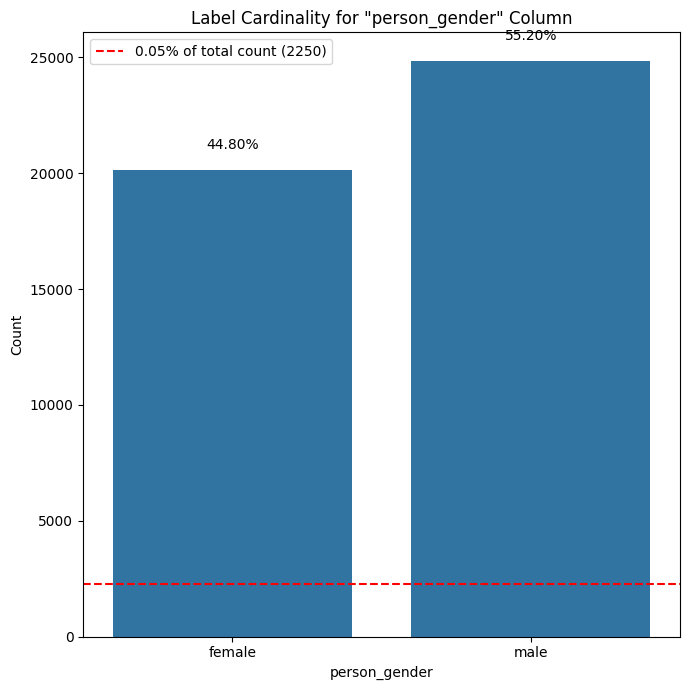

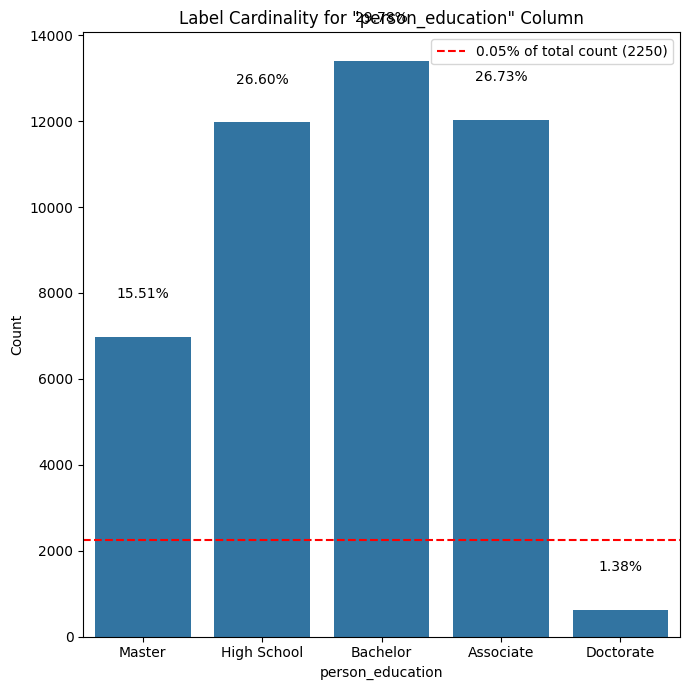

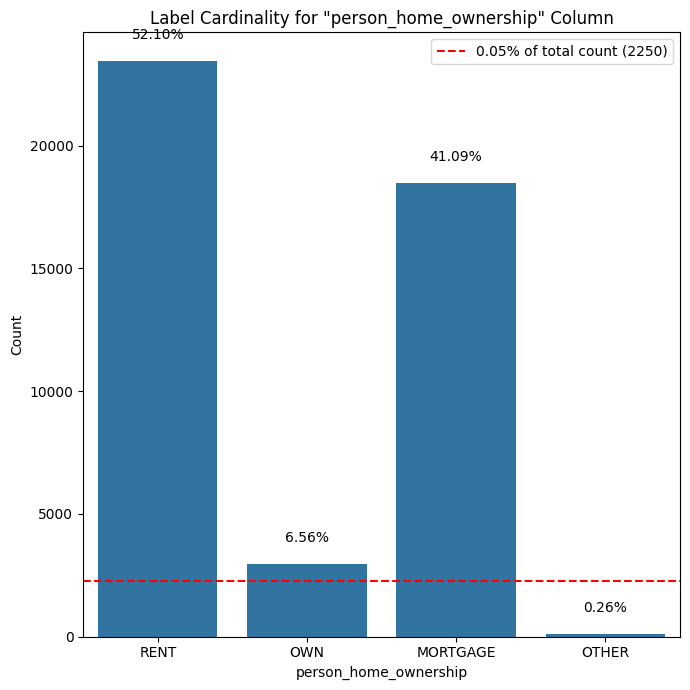

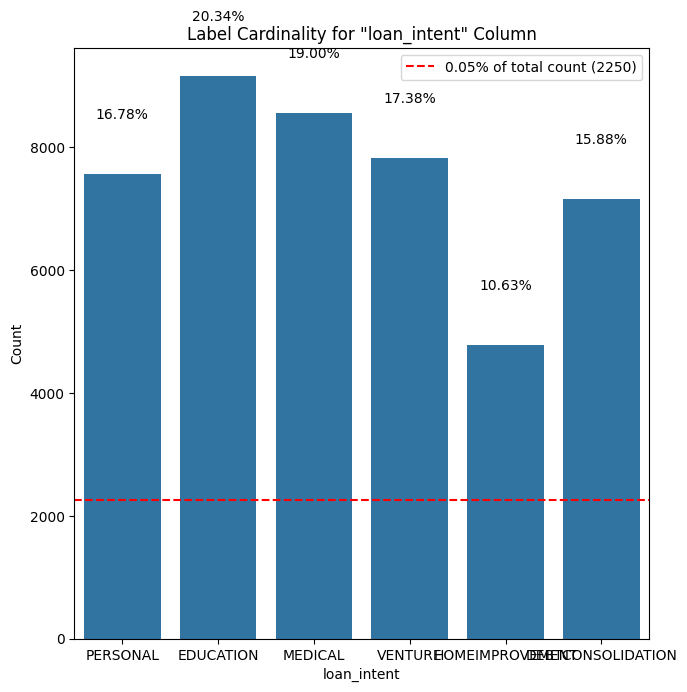

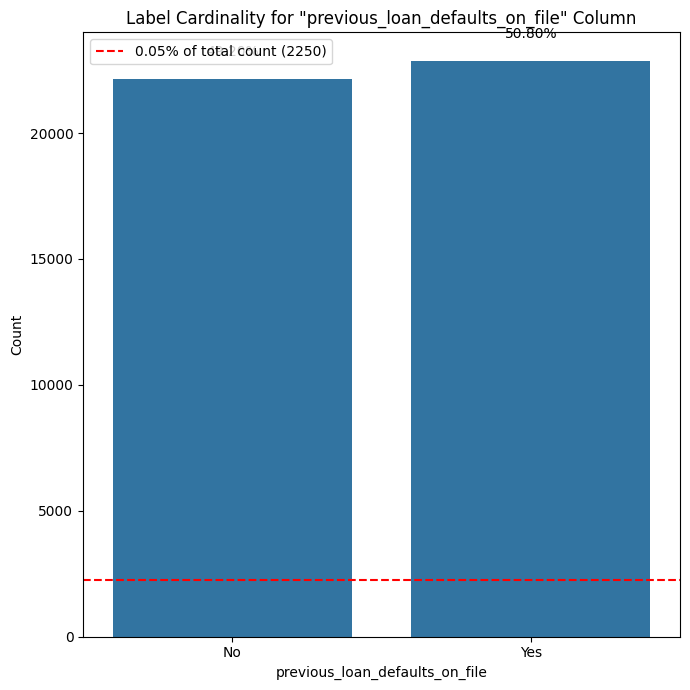

In [9]:
def plot_categorical_column(dataframe, column):

    plt.figure(figsize=(7, 7))
    ax = sns.countplot(x=dataframe[column])
    total_count = len(dataframe[column])
    threshold = 0.05 * total_count
    category_counts = dataframe[column].value_counts(normalize=True) * 100
    ax.axhline(threshold, color='red', linestyle='--', label=f'0.05% of total count ({threshold:.0f})')

    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total_count) * 100
        ax.text(p.get_x() + p.get_width() / 2., height + 0.02 * total_count, f'{percentage:.2f}%', ha="center")

    plt.title(f'Label Cardinality for "{column}" Column')
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.tight_layout()

    plt.legend()
    plt.show()

for col in cat_cols:
    plot_categorical_column(df, col)


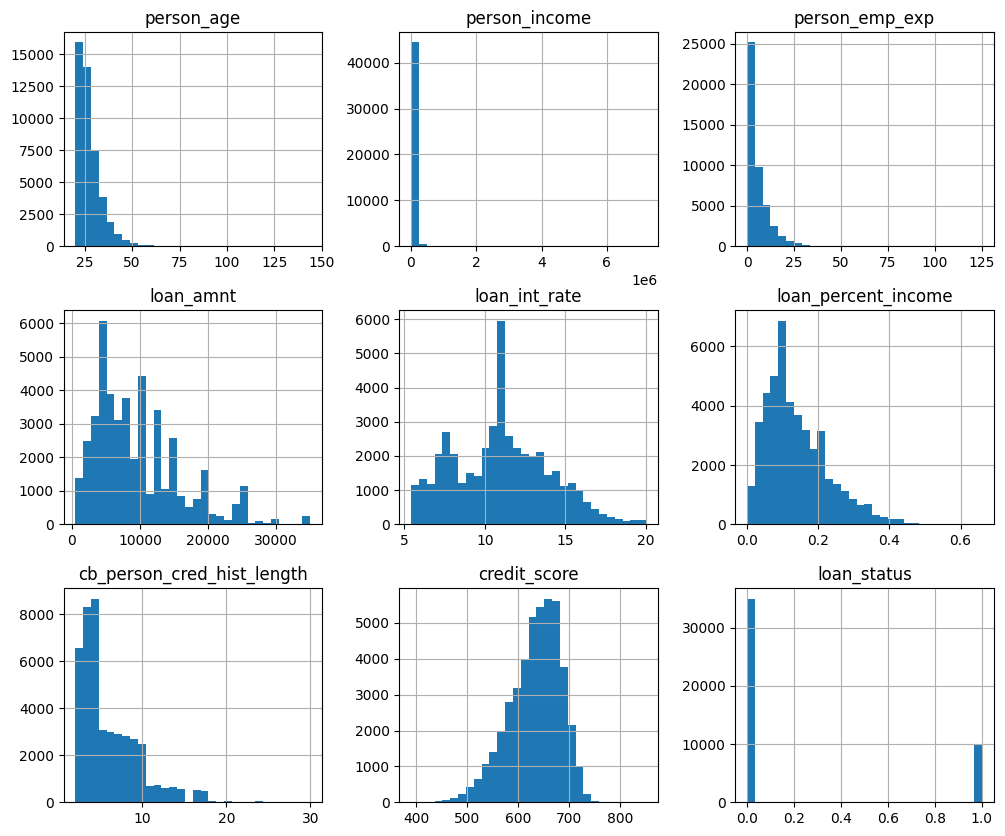

In [10]:
df[num_cols].hist(bins=30, figsize=(12,10))
plt.show()

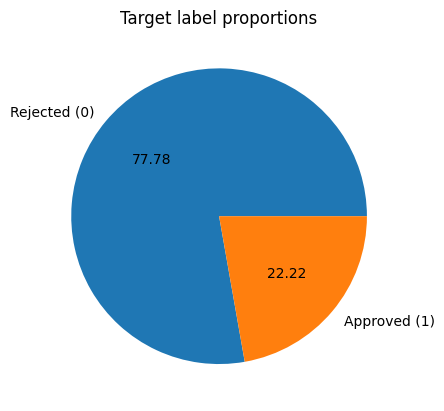

In [11]:
label_prop = df['loan_status'].value_counts()

plt.pie(label_prop.values, labels=['Rejected (0)', 'Approved (1)'], autopct='%.2f')
plt.title('Target label proportions')
plt.show()

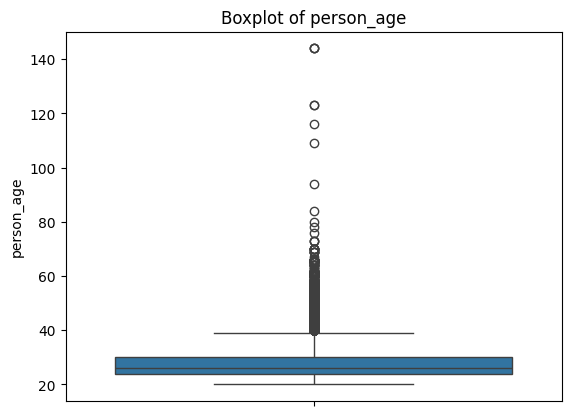

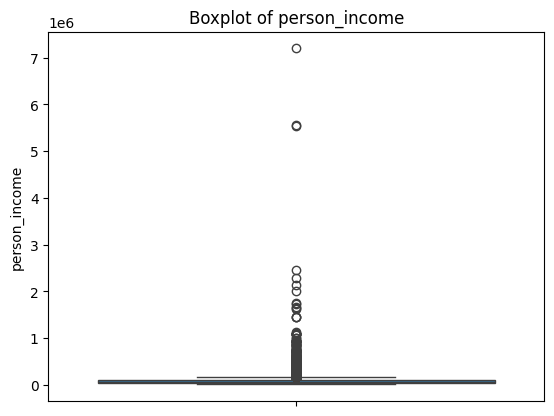

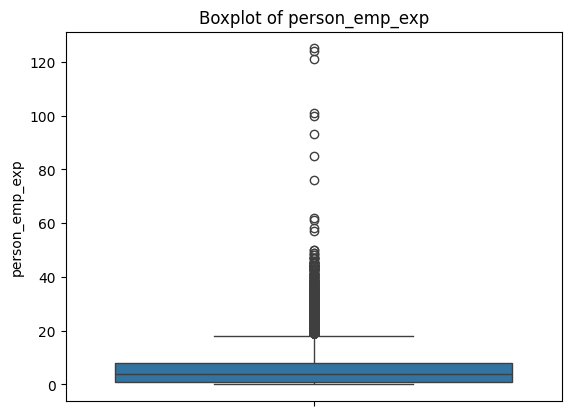

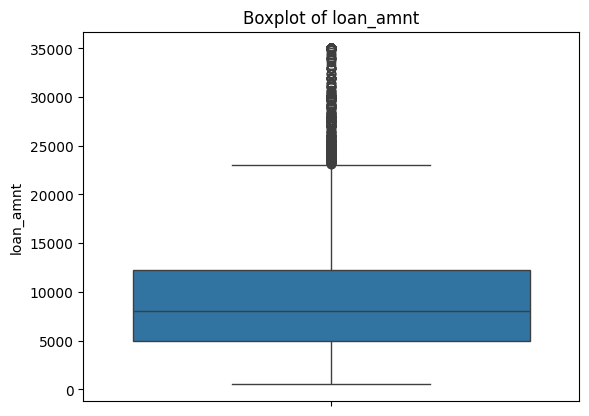

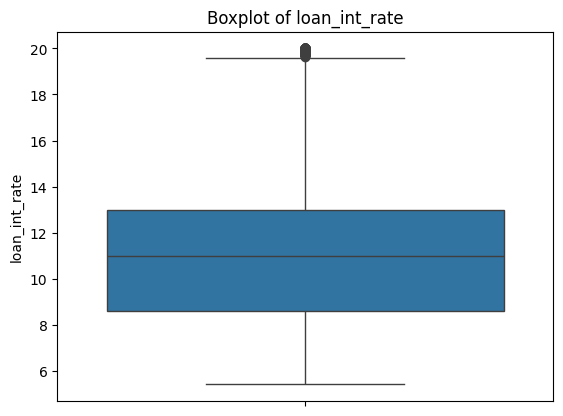

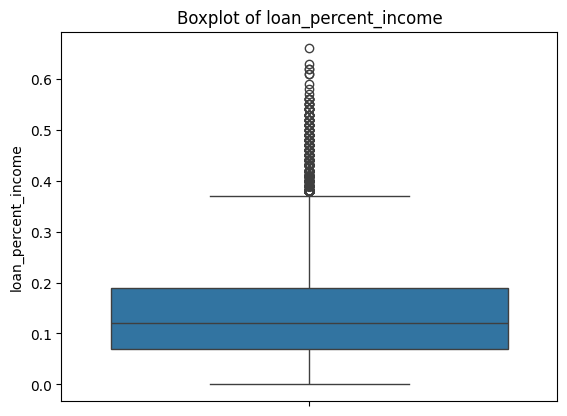

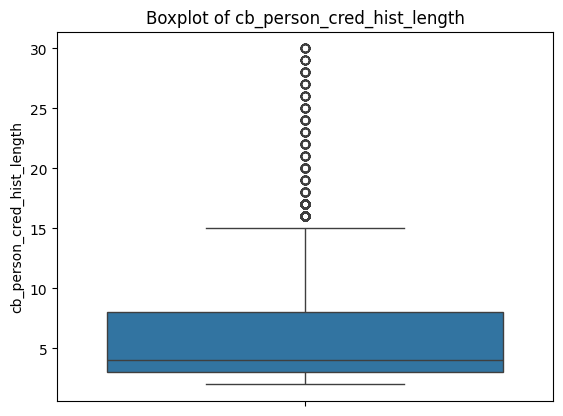

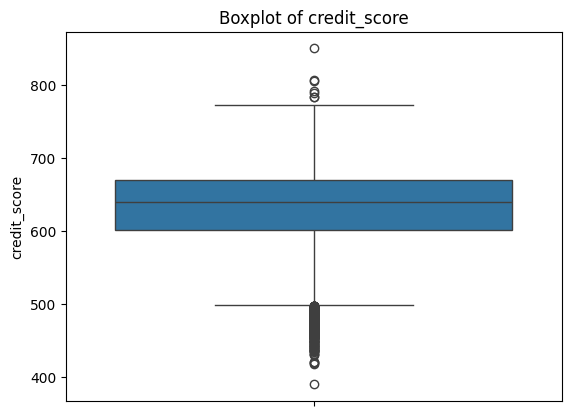

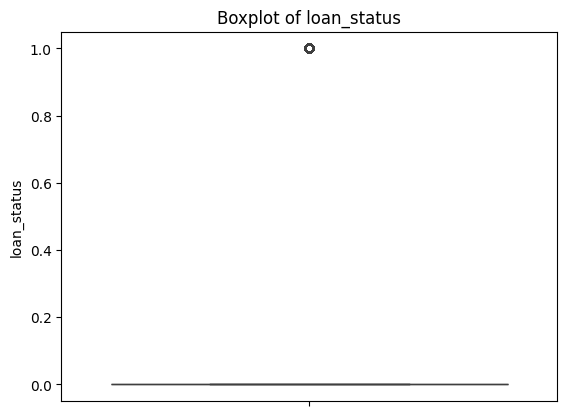

In [12]:
for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [13]:
!pip install feature-engine


In [14]:
skewed_cols = ['person_age', 'person_income', 'person_emp_exp',
               'loan_amnt', 'loan_percent_income',
               'cb_person_cred_hist_length', 'credit_score']

norm_cols= ['loan_int_rate']

In [15]:
mms = MinMaxScaler()
ss = StandardScaler()

df[skewed_cols] = ss.fit_transform(df[skewed_cols])
df[skewed_cols] = ss.transform(df[skewed_cols])

df[norm_cols] = mms.fit_transform(df[norm_cols])
df[norm_cols] = mms.transform(df[norm_cols])

In [16]:
df['person_education'].replace({
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate':4
}, inplace=True)

df['person_education'].replace({
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate':4
}, inplace=True)



In [17]:
df["person_home_ownership"].value_counts()

person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

In [18]:
df["loan_intent"].value_counts()

loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

In [19]:
df["previous_loan_defaults_on_file"].value_counts()

previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64

In [20]:
df["person_gender"].value_counts()

person_gender
male      24841
female    20159
Name: count, dtype: int64

In [21]:
gender_mapping = {'male': 0, 'female': 1}
home_ownership_mapping = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}
loan_intent_mapping = {'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2, 'VENTURE': 3, 'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5}
previous_loan_defaults_mapping = {'No': 0, 'Yes': 1}


df['person_gender'] = df['person_gender'].map(gender_mapping)
df['person_home_ownership'] = df['person_home_ownership'].map(home_ownership_mapping)
df['loan_intent'] = df['loan_intent'].map(loan_intent_mapping)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map(previous_loan_defaults_mapping)

In [22]:
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [23]:
from feature_engine.outliers import OutlierTrimmer

trimmer = OutlierTrimmer(capping_method='iqr', tail='right',
                        variables= ['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt',
       'loan_intent', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file'])

df2 = trimmer.fit_transform(df)

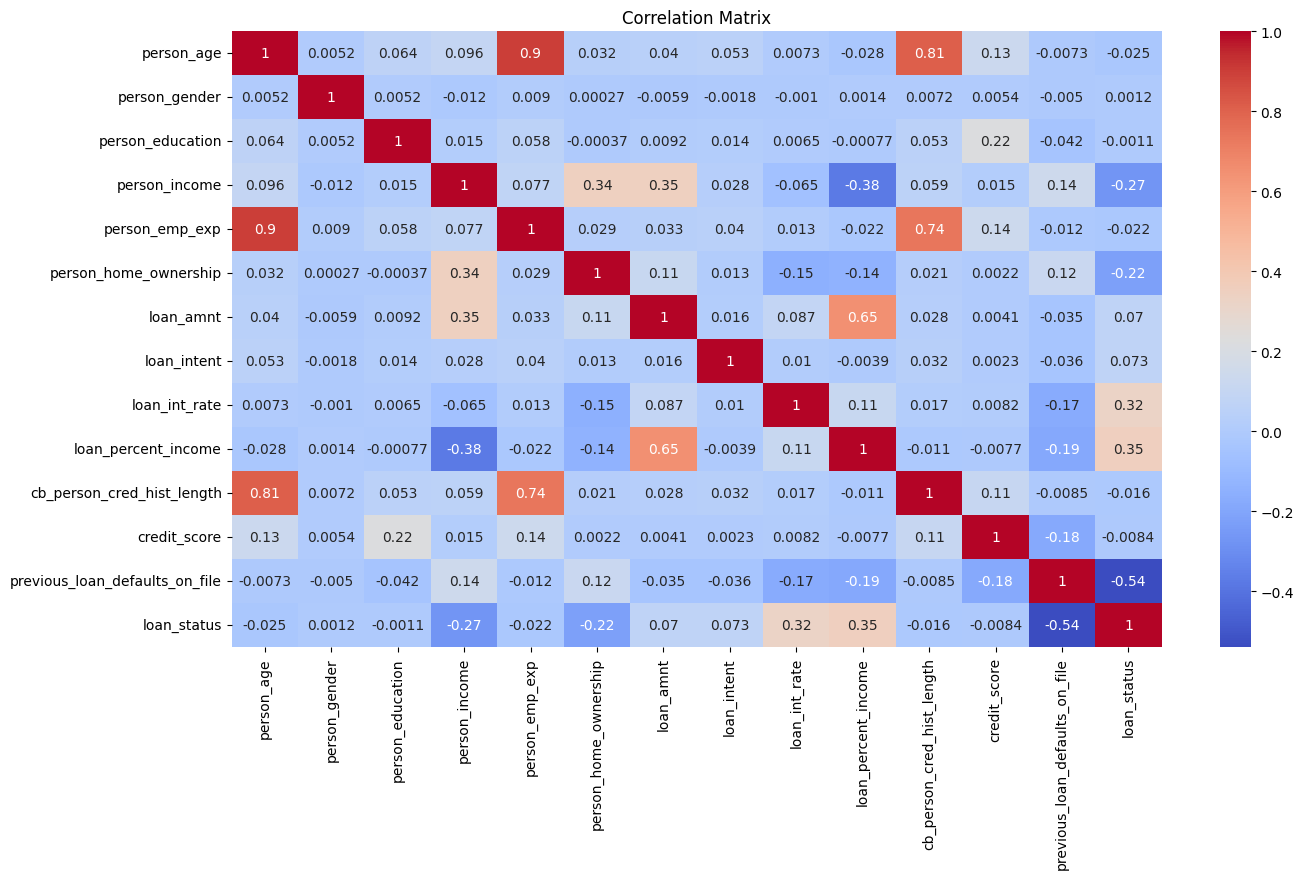

In [24]:
plt.figure(figsize=(15, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [25]:
threshold = 0.1

correlation_matrix = df2.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["loan_status"]) > threshold].tolist()
high_corr_features.remove("loan_status")
print(high_corr_features)

X_selected = df[high_corr_features]
Y = df["loan_status"]

['person_income', 'person_home_ownership', 'loan_int_rate', 'loan_percent_income', 'previous_loan_defaults_on_file']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36000, 5), (36000,), (9000, 5), (9000,))

In [27]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [28]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [29]:
model.score(X_train, y_train)

0.8711111111111111

In [30]:
Y_pred = model.predict(X_test)

In [31]:
print(accuracy_score(y_test, Y_pred))

0.8658888888888889


In [32]:
model2 = SVC()
model2.fit(X_train, y_train)

SVC()

In [33]:
Y_pred2 = model2.predict(X_test)
print(accuracy_score(y_test, Y_pred2))

0.852


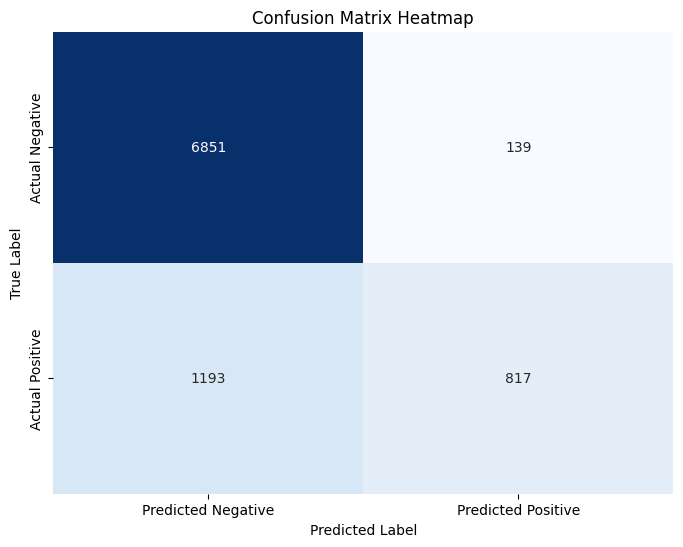

In [34]:
conf_matrix2 =confusion_matrix(y_test, Y_pred2)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [35]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [36]:
y_pred_knn = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 88.04%


In [37]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      6990
           1       0.75      0.70      0.72      2010

    accuracy                           0.88      9000
   macro avg       0.83      0.82      0.82      9000
weighted avg       0.88      0.88      0.88      9000



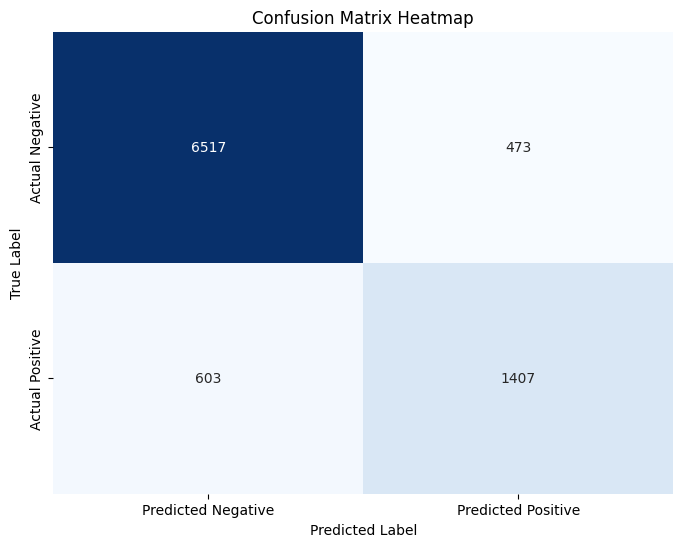

In [38]:
conf_matrix3 =confusion_matrix(y_test, y_pred_knn)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()